# Procrustes-like alignment for SPD matrices

In this notebook I will perform some simulations to check the results from the report (I will report here the results that I will check without a proof).

The general problem is to find the *optimal* way to align a set of SPD matrices to a common reference. This problem can be split in two parts:

  1. given a reference, what is the optimal rotation for each matrix in the set?
  2. which is the optimal reference
 
I start by importing the used packages and defining the hyperparameters

In [1]:
%matplotlib inline

import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('talk', 'darkgrid')

plt.rcParams["figure.figsize"] = (15,4)

seed = 0
rng = default_rng(seed)

# Hyperparameters: number of matrices and their dimensions
n, p = 10, 3

# Hyperparameters: simulations numbers
n_tests = 5
n_rep = 30

Then I generate a set of random SPD matrices $\Sigma_i$ that we can consider a sample dataset.

In [2]:
Sigmas = rng.normal(size=(n, p, p))
Sigmas = np.einsum('...ij,...kj', Sigmas, Sigmas)

Then I define the various function that I will need (along with some helper utilities). Mainly, I will need the distance induced by the Frobenius norm
$$
    d_F(A, B)^2 = \left\Vert A-B\right\Vert^2_F = tr\left((A-B)^\top(A-B)\right)
$$
the riemannian distance (with $Log$ the matrix logarithm, which for the SPD matrices is well defined)
$$
    d_R(A, B)^2 = \left\Vert Log\left(A^{-1/2}BA^{-1/2}\right)\right\Vert^2_F
$$

Moreover, the rotation in this context is defined as
$$
    T_\Omega(\Sigma) = \Omega\Sigma\Omega^\top
$$

In [3]:
# Functions
isqrt = lambda x: 1. / np.sqrt(x)
funs = {'sqrt': np.sqrt,
        'isqrt': isqrt,
        'log': np.log,
        'exp': np.exp}

def norm_frob_squared(X):
    return np.einsum('...ji,...ji', X, X)

def dist_frob_squared(X, Y):
    return norm_frob_squared(X - Y)

def transform_mat(X, func='sqrt'):
    u, v = np.linalg.eigh(X)
    return np.einsum('...ij,...j,...kj', v, funs[func](u), v)

def dist_riem_squared(X, Y):
    x = transform_mat(X, 'isqrt')
    mid = np.einsum('...ij,...jk,...kl', x, Y, x)
    return norm_frob_squared(transform_mat(mid, 'log'))

def costfunc(X, Y):
    return np.sum(dist_riem_squared(X, Y))

def costfuncproc(X, Y):
    return np.sum(dist_frob_squared(X, Y))

def rotate(X, Omega):
    return np.einsum('...ij,...jk,...lk', Omega, X, Omega)



## Results from the report
As is proven in the report, the set of optimal rotation matrices, given the eigenvalue decompositions $\Gamma_i\Lambda_i\Gamma_i^\top = \Sigma_i$ and $\Gamma_M\Lambda_M\Gamma_M=M$ is
$$
    \Omega_i = \Gamma_M\Gamma_i^\top
$$

The optimal reference matrix is obtained by combining the optimal eigenvalues and the optimal eigenvectors, which are separately
$$
    \lambda_{Mh} = \left[\prod_i^n\lambda_{ih}\right]^{1/n}
$$
and
$$
    \Gamma_M = UV^\top
$$
with $UDV^\top = \sum_i\Gamma_i$ the singular value decomposition of the sum of $\Gamma_i$

In [4]:
def optimal_rotation(X, M):
    _, g_m = np.linalg.eigh(M)
    _, g_x = np.linalg.eigh(X)
    return np.einsum('...ij,...kj', g_m, g_x)

def optimal_reference_eigval(X):
    u = np.linalg.eigvalsh(X)
    return np.power(np.prod(u, axis=0), 1 / X.shape[0])

def optimal_reference_eigvec(X):
    _, vs = np.linalg.eigh(Sigmas)
    U, _, V = np.linalg.svd(np.sum(vs, axis=0))
    return np.einsum('...ij,...jk', U, V)

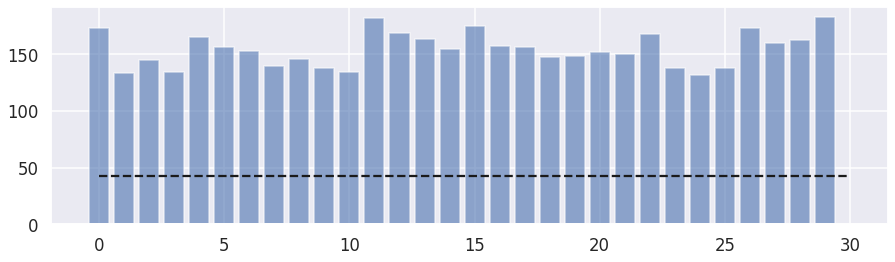

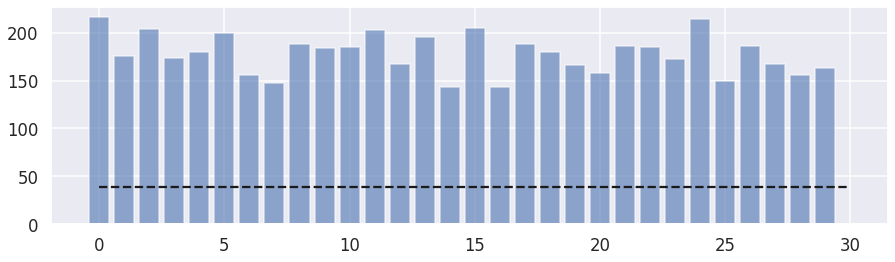

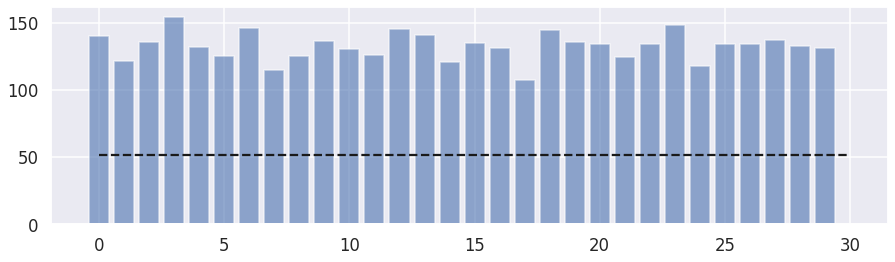

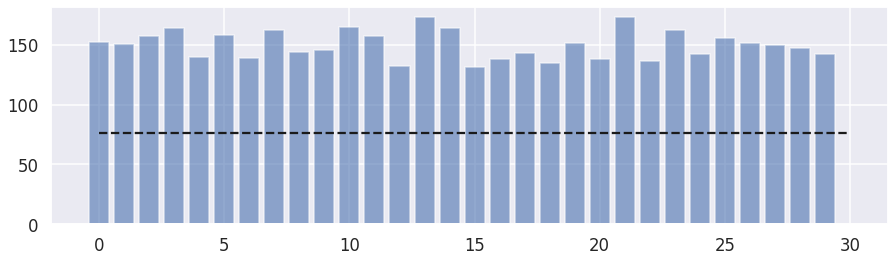

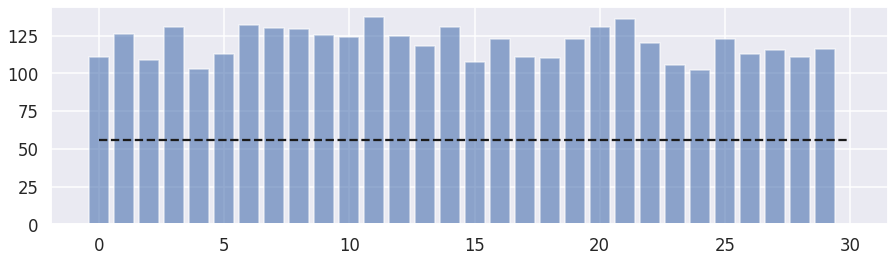

In [5]:
# First simulation: optimal rotation
for i in range(n_tests):
    M = rng.normal(size=(p, p))
    M = np.einsum('...ij,...kj', M, M)
    
    om_opt = optimal_rotation(Sigmas, M)
    cost_opt = costfunc(M, rotate(Sigmas, om_opt))
    costs = []
    
    for j in range(n_rep):
        omega = np.linalg.qr(rng.normal(size=(p, p)))[0]
        costs.append(costfunc(M, rotate(Sigmas, omega)))
    
    costs = np.array(costs)
    min_costs = np.where((costs < cost_opt) & (~np.isclose(costs, cost_opt)), costs, 0)
    
    plt.bar(range(n_rep), costs, alpha=0.6)
    plt.bar(range(len(min_costs)), min_costs, color='r')
    plt.hlines(y=cost_opt, xmin=0, xmax=n_rep, colors='k', linestyle='dashed')
    plt.show()

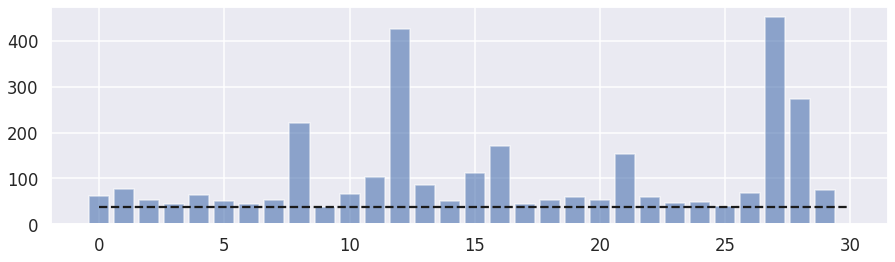

In [6]:
# Second simulation: Eigenvalues of the optimal reference
lam_opt = np.diag(optimal_reference_eigval(Sigmas))
rot_opt = optimal_rotation(Sigmas, lam_opt)
cost_opt = costfunc(lam_opt, rotate(Sigmas, rot_opt))

costs = []

for j in range(n_rep):
    M = rng.normal(size=(p, p))
    M = np.einsum('...ij,...kj', M, M)
    rot = optimal_rotation(Sigmas, M)
    costs.append(costfunc(M, rotate(Sigmas, rot)))
costs = np.array(costs)
min_costs = np.where((costs < cost_opt) & (~np.isclose(costs, cost_opt)), costs, 0)

plt.bar(range(n_rep), costs, alpha=0.6)
plt.bar(range(len(min_costs)), min_costs, color='r')
plt.hlines(y=cost_opt, xmin=0, xmax=n_rep, colors='k', linestyle='dashed')
plt.show()

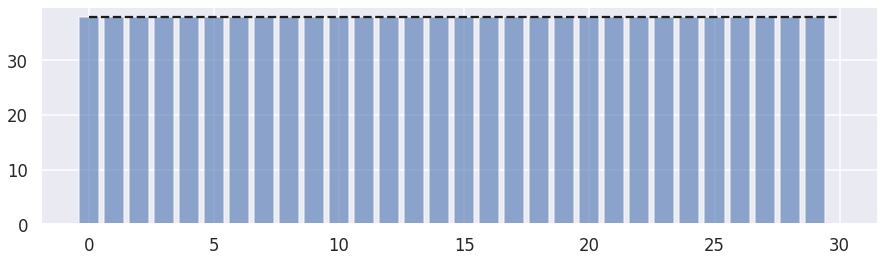

In [7]:
# Third simulation: Independence from the eigenvectors
lam_opt = optimal_reference_eigval(Sigmas)
rot_opt = optimal_rotation(Sigmas, np.diag(lam_opt))
cost_opt = costfunc(np.diag(lam_opt), rotate(Sigmas, rot_opt))

costs = []

for j in range(n_rep):
    M = np.linalg.qr(rng.normal(size=(p, p)))[0]
    M = np.einsum('...ij,...j,...kj', M, lam_opt, M)
    rot = optimal_rotation(Sigmas, M)
    costs.append(costfunc(M, rotate(Sigmas, rot)))
costs = np.array(costs)
min_costs = np.where((costs < cost_opt) & (~np.isclose(costs, cost_opt)), costs, 0)

plt.bar(range(n_rep), costs, alpha=0.6)
plt.bar(range(len(min_costs)), min_costs, color='r')
plt.hlines(y=cost_opt, xmin=0, xmax=n_rep, colors='k', linestyle='dashed')
plt.show()

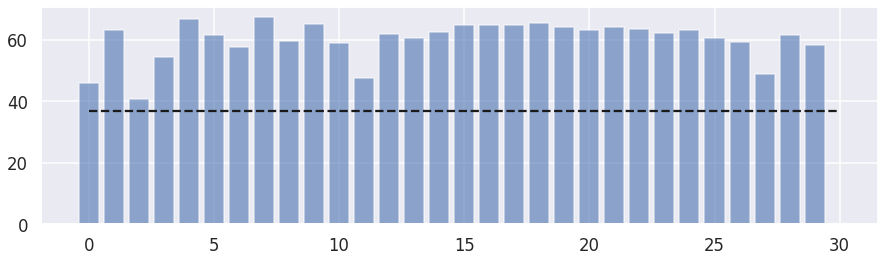

In [8]:
# Fourth simulation: Eigenvectors of optimal reference
_, vs = np.linalg.eigh(Sigmas)
U, _, V = np.linalg.svd(np.sum(vs, axis=0))

opt_gam = np.einsum('...ij,...jk', U, V)
cost_opt = costfuncproc(np.einsum('...ij,...kj', opt_gam, vs), np.identity(p))

costs = []

for j in range(n_rep):
    M = np.linalg.qr(rng.normal(size=(p, p)))[0]
    costs.append(costfuncproc(np.einsum('...ij,...kj', M, vs), np.identity(p)))
costs = np.array(costs)
min_costs = np.where((costs < cost_opt) & (~np.isclose(costs, cost_opt)), costs, 0)
  
plt.bar(range(n_rep), costs, alpha=0.6)
plt.bar(range(len(min_costs)), min_costs, color='r')
plt.hlines(y=cost_opt, xmin=0, xmax=n_rep, colors='k', linestyle='dashed')
plt.show()